In [1]:
import datetime
from pathlib import Path
from typing import Dict, List, Union

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

In [2]:
def weighted_avg(x, weight, factor):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        tmp = x[[weight, factor]].dropna()
        weighted_sum = (tmp[weight] * tmp[factor]).sum()
        count_sum = tmp[weight].sum()
        return weighted_sum / count_sum

In [3]:
def load_data(locus_weights_path: Union[str, Path],
              temperature_path: Union[str, Path],
              locus_group_matching_path: Union[str, Path],
              fresh_water_dates_path: Union[str, Path],
              sw_fw_matching_path: Union[str, Path],
              final_locus_weighted_path: Union[str, Path],
              mortality_path: Union[str, Path]) -> Dict['str', pd.DataFrame]:
    
    locus_weights = pd.read_csv(locus_weights_path)
    locus_weights.starttime = pd.to_datetime(locus_weights.starttime, format=TIME_FORMAT)
    locus_weights.endtime = pd.to_datetime(locus_weights.endtime, format=TIME_FORMAT)
    
    temperature = pd.read_csv(temperature_path)
    temperature.event_date = pd.to_datetime(temperature.event_date, format=TIME_FORMAT)
    temperature.locus_group_id=temperature.locus_group_id.astype(INT_TYPE)
    temperature['event_year'] = temperature['event_date'].dt.year

    locus_group_matching = pd.read_csv(locus_group_matching_path)
    locus_group_matching = locus_group_matching.astype(INT_TYPE)

    fresh_water_dates = pd.read_csv(fresh_water_dates_path)
    for d in ['first_movement_date', 'first_feeding_date', 'shipout_date']:
        fresh_water_dates[d] = pd.to_datetime(fresh_water_dates[d], format=TIME_FORMAT)

    sw_fw_matching = pd.read_csv(sw_fw_matching_path)
    sw_fw_cols = ['target_seawater_locus_id',
                  'transport_date',
                  'ponding_date',
                  'pretransfer_fw_locus_population_id',
                  'fish_count_shipped_out',
                  'avg_weight_g_stocked']
    sw_fw_matching = sw_fw_matching[sw_fw_matching.origin_site_type == 'Freshwater'][sw_fw_cols]
    sw_fw_matching.pretransfer_fw_locus_population_id = sw_fw_matching.\
    pretransfer_fw_locus_population_id.astype(INT_TYPE)

    final_locus_weighted = pd.read_csv(final_locus_weighted_path)
    final_locus_weighted.event_date = pd.to_datetime(final_locus_weighted.event_date)

    mortality = None #pd.read_csv(mortality_path)
    #mortality['transfer_date'] = pd.to_datetime(mortality['transfer_date'], format=TIME_FORMAT)
    #mortality['transport_year']= mortality['transfer_date'].dt.year
    
    dataframes = {
        'temperature': temperature,
        'locus_weigts': locus_weights,
        'locus_group_matching': locus_group_matching,
        'final_locus_weighted': final_locus_weighted,
        'fresh_water_dates': fresh_water_dates,
        'sw_fw_matching': sw_fw_matching,
        'mortality': mortality
    }
    
    return dataframes

In [4]:
dataframes = load_data(locus_weights_path='../data/evt_movement_ratio_with_dates.csv',
                       temperature_path='../data/temperature_for_CAM.csv',
                       locus_group_matching_path='../data/locus_locus_group_matching.csv',
                       fresh_water_dates_path='../data/FW_cycle_dates.csv',
                       sw_fw_matching_path='../data/seawater_freshwater_matching.csv',
                       final_locus_weighted_path='../data/lw_alldates_final.csv',
                       mortality_path='../data/tmp_target.csv')

temperature = dataframes['temperature']
locus_weights = dataframes['locus_weigts']
locus_group_matching = dataframes['locus_group_matching']
final_locus_weighted = dataframes['final_locus_weighted']
fresh_water_dates = dataframes['fresh_water_dates']
sw_fw_matching = dataframes['sw_fw_matching']
mortality = dataframes['mortality']

In [5]:
lw_dates = locus_weights.groupby('final_locus_population_id').agg({'starttime': 'min', 'endtime': 'max'})
lw_dates.starttime = pd.to_datetime(lw_dates.starttime, format=TIME_FORMAT)
lw_dates.endtime = pd.to_datetime(lw_dates.endtime, format=TIME_FORMAT)
lw_dates['FW_cycle_length'] = (lw_dates.endtime - lw_dates.starttime).dt.days + 1  # to be checked (?)
lw_dates['starttime_year'] = lw_dates['starttime'].dt.year
lw_dates = lw_dates[lw_dates.starttime_year>=2017]  # issues with temperature readings for 2015-2016

In [6]:
lw_dates

,starttime,endtime,FW_cycle_length,starttime_year
final_locus_population_id,,,,
36783130,2017-01-04,2018-04-13,465,2017
36783339,2017-01-04,2018-04-17,469,2017
36783413,2017-01-04,2018-05-07,489,2017
36783453,2017-01-04,2018-05-07,489,2017
36783456,2017-01-04,2018-04-09,461,2017
...,...,...,...,...
194761270,2022-11-09,2023-12-11,398,2022
194761272,2022-11-09,2023-12-11,398,2022
194761274,2022-11-09,2023-12-11,398,2022


In [7]:
final_locus_locus_group_weighted = final_locus_weighted.merge(locus_group_matching,
                                                              left_on='historic_locus_id',
                                                              right_on='locus_id',
                                                              how='left')
final_locus_locus_group_weighted.drop(columns='locus_id',inplace=True)

### feed

In [8]:
feed_data = pd.read_csv('../data/feed_UPS_Petrohue.csv')
print(feed_data.shape)
feed_data = feed_data.merge(locus_group_matching, how='inner', on='locus_id')
print(feed_data.shape)
feed_data.rename(columns={'start_reg_time': 'event_date'}, inplace=True)
feed_data['event_date'] = pd.to_datetime(feed_data['event_date']) #, format=TIME_FORMAT
feed_data['event_year'] = feed_data['event_date'].dt.year

(910765, 5)
(2544051, 6)


In [9]:
feed_data[feed_data['locus_population_id']==194761283]

,locus_id,mrts_feed_id,event_date,amount,locus_population_id,locus_group_id,event_year


In [10]:
locus_avg_weight = pd.read_csv('../data/FW_locus_weight_UPS_Petrohue.csv')
locus_avg_weight['open_biomass_kg'] = locus_avg_weight ['open_count'] * locus_avg_weight ['open_weight_g'] / 1000
locus_avg_weight['close_biomass_kg'] = locus_avg_weight ['close_count'] * locus_avg_weight ['close_weight_g'] / 1000
locus_avg_weight['event_date'] = pd.to_datetime(locus_avg_weight['event_date'], format=TIME_FORMAT)
locus_avg_weight=locus_avg_weight[locus_avg_weight.close_count>0]
locus_avg_weight

,locus_id,locus_population_id,event_date,open_count,open_weight_g,close_count,close_weight_g,open_biomass_kg,close_biomass_kg
0,3046035,36787679,2018-09-06,0,0.00,52344,65.00,0.00000,3402.36000
2,3046035,36787705,2018-09-07,0,0.00,119438,65.00,0.00000,7763.47000
3,3046035,36787705,2018-09-08,119438,65.00,119395,65.00,7763.47000,7760.67500
4,3046035,36787705,2018-09-09,119395,65.00,119362,65.00,7760.67500,7758.53000
5,3046035,36787705,2018-09-10,119362,65.00,119305,65.00,7758.53000,7754.82500
...,...,...,...,...,...,...,...,...,...
718176,7184140,194518463,2022-09-17,52301,152.06,52300,152.29,7952.89006,7964.76700
718177,7184140,194518463,2022-09-18,52300,152.29,52299,152.75,7964.76700,7988.67225
718178,7184140,194518463,2022-09-19,52299,152.75,52298,152.75,7988.67225,7988.51950
718179,7184140,194518463,2022-09-20,52298,152.75,52291,152.75,7988.51950,7987.45025


array([-0.24812291, -0.23816045, -0.22819799, -0.21823554, -0.20827308,
       -0.19831062, -0.18834816, -0.1783857 , -0.16842325, -0.15846079,
       -0.14849833, -0.13853587, -0.12857341, -0.11861095, -0.1086485 ,
       -0.09868604, -0.08872358, -0.07876112, -0.06879866, -0.0588362 ,
       -0.04887375, -0.03891129, -0.02894883, -0.01898637, -0.00902391,
        0.00093854,  0.010901  ,  0.02086346,  0.03082592,  0.04078838,
        0.05075084,  0.06071329,  0.07067575,  0.08063821,  0.09060067,
        0.10056313,  0.11052558,  0.12048804,  0.1304505 ,  0.14041296,
        0.15037542,  0.16033788,  0.17030033,  0.18026279,  0.19022525,
        0.20018771,  0.21015017,  0.22011263,  0.23007508,  0.24003754,
        0.25      ])

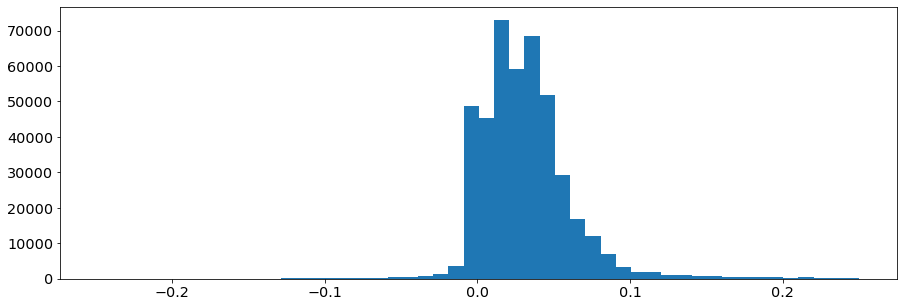

In [36]:
# tmp=((locus_avg_weight['close_biomass_kg'] - locus_avg_weight['open_biomass_kg']) / locus_avg_weight['open_biomass_kg'])
# (n, bins, patches)=plt.hist(tmp[tmp.between(-.25,.25)&(tmp!=0)],bins=50)
# bins

In [11]:
#grouping, merging feed amount data and locus average weight data to calculate SFR, filtering
feed_data_by_locus = pd.DataFrame(feed_data.groupby(['locus_id', 'event_date'])['amount'].mean()).reset_index()
print(len(feed_data_by_locus))
feed_data_by_locus=feed_data_by_locus.merge(locus_avg_weight,how='left')
print(len(feed_data_by_locus))
feed_data_by_locus=feed_data_by_locus[feed_data_by_locus.amount<feed_data_by_locus.amount.quantile(.999)]
print(len(feed_data_by_locus))
feed_data_by_locus=feed_data_by_locus[feed_data_by_locus.close_biomass_kg!=feed_data_by_locus.open_biomass_kg]
print(len(feed_data_by_locus))
feed_data_by_locus=feed_data_by_locus[feed_data_by_locus.open_biomass_kg>0]
print(len(feed_data_by_locus))
feed_data_by_locus['SFR'] = feed_data_by_locus['amount'] / feed_data_by_locus['open_biomass_kg'] 
feed_data_by_locus['SGR'] = 100 * ( feed_data_by_locus['close_weight_g'] / feed_data_by_locus['open_weight_g'] - 1)
feed_data_by_locus['FCR'] = feed_data_by_locus['amount'] / (feed_data_by_locus['close_biomass_kg']-feed_data_by_locus['open_biomass_kg'])

q1 = feed_data_by_locus['SGR'].quantile(.99)
q2 = feed_data_by_locus['FCR'].quantile(.99)
#feed_data_by_locus_ = feed_data_by_locus_[feed_data_by_locus_.SFR < feed_data_by_locus_['SFR'].quantile(.99)]
#feed_data_by_locus_ = feed_data_by_locus_[feed_data_by_locus_.SFR < 0.15]
# print(len(feed_data_by_locus_))
feed_data_by_locus = feed_data_by_locus[feed_data_by_locus.SGR.between(0,q1)]
print(len(feed_data_by_locus))
feed_data_by_locus = feed_data_by_locus[feed_data_by_locus.FCR.between(0,q2)]
print(len(feed_data_by_locus))

876998
876998
875998
875876
418986
409898
392943


In [12]:
#feed_data_by_locus
feed_data_by_locus[feed_data_by_locus['locus_population_id']==194761283]

,locus_id,event_date,amount,locus_population_id,open_count,open_weight_g,close_count,close_weight_g,open_biomass_kg,close_biomass_kg,SFR,SGR,FCR


In [13]:
#plot histograms

In [19]:
# Fit a Gaussian Mixture Model to calculate two modes
gmm = GaussianMixture(n_components=4)
gmm.fit(feed_data_by_locus['SGR'].values.reshape(-1, 1))

# Get the means of the Gaussian components
means = gmm.means_.flatten()

Text(0.5, 0, 'SGR, %')

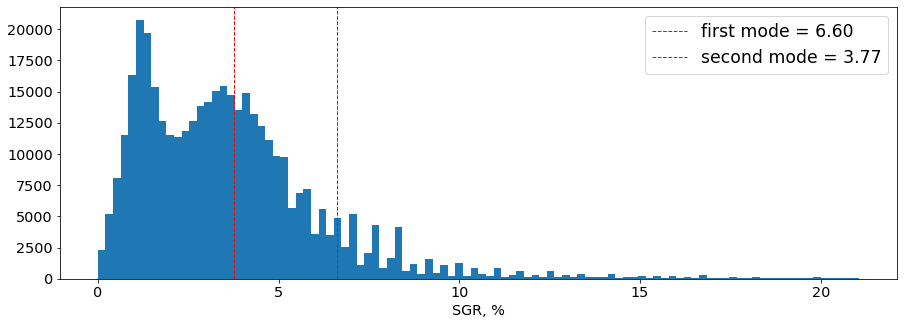

In [20]:
# Plot the histogram
hist, bin_edges, _ = plt.hist(feed_data_by_locus['SGR'], bins=100)

plt.axvline(means[1], color='red', linestyle='dashed', label=f'first mode = {means[1]:.2f}', linewidth=1)
plt.axvline(means[0], color='red', linestyle='dashed', label=f'second mode = {means[0]:.2f}', linewidth=1)

# # Display the modes as text on the plot
# plt.text(0.6, 0.9, f"Modes: {means[0]:.3f}, {means[1]:.3f}", transform=plt.gca().transAxes)

plt.legend()
plt.xlabel('SGR, %')

# plt.savefig('Visualisation\Histograms\SGR_FW_aggregated_on_locus_level_histogram.jpg')

In [257]:
# Fit a Gaussian Mixture Model to calculate two modes
gmm = GaussianMixture(n_components=3)
gmm.fit(feed_data_by_locus['FCR'].values.reshape(-1, 1))

# Get the means of the Gaussian components
means = gmm.means_.flatten()

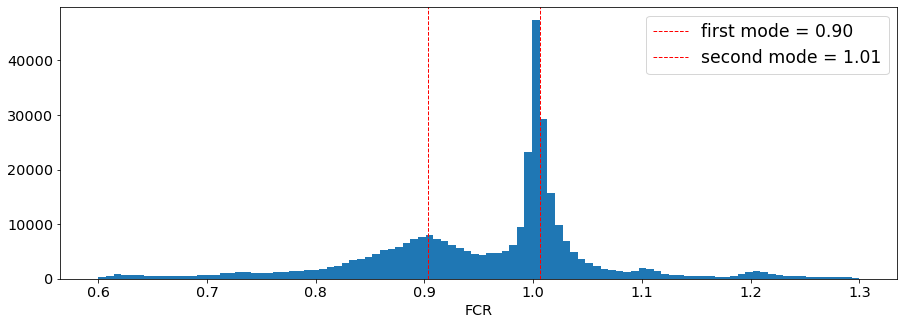

In [264]:
# Plot the histogram
hist, bin_edges, _ = plt.hist(feed_data_by_locus[feed_data_by_locus.FCR.between(.6,1.3)]['FCR'], bins=100)

plt.axvline(means[2], color='red', linestyle='dashed', label=f'first mode = {means[2]:.2f}', linewidth=1)
# plt.axvline(means[1], color='red', linestyle='dashed', label=f'second mode = {means[1]:.2f}', linewidth=1)
plt.axvline(means[0], color='red', linestyle='dashed', label=f'second mode = {means[0]:.2f}', linewidth=1)
# plt.axvline(means[3], color='red', linestyle='dashed', label=f'first mode = {means[3]:.2f}', linewidth=1)

# # Display the modes as text on the plot
# plt.text(0.6, 0.9, f"Modes: {means[0]:.3f}, {means[1]:.3f}", transform=plt.gca().transAxes)

plt.legend()
plt.xlabel('FCR')

# plt.savefig('Visualisation\Histograms\FCR_FW_aggregated_on_locus_level_histogram.jpg')

In [235]:
# Fit a Gaussian Mixture Model to calculate two modes
gmm = GaussianMixture(n_components=3)
gmm.fit(feed_data_by_locus_['SFR'].values.reshape(-1, 1))

# Get the means of the Gaussian components
means = gmm.means_.flatten()

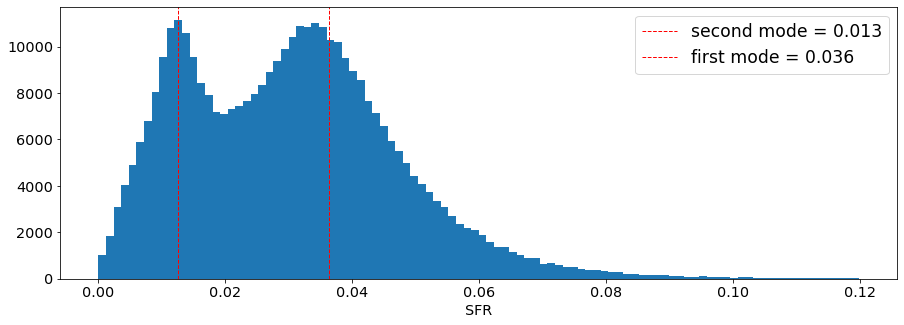

In [242]:
# Plot the histogram
hist, bin_edges, _ = plt.hist(feed_data_by_locus[feed_data_by_locus.SFR<.12]['SFR'], bins=100)

plt.axvline(means[2], color='red', linestyle='dashed', label=f'second mode = {means[2]:.3f}', linewidth=1)
plt.axvline(means[0], color='red', linestyle='dashed', label=f'first mode = {means[0]:.3f}', linewidth=1)

# # Display the modes as text on the plot
# plt.text(0.6, 0.9, f"Modes: {means[0]:.3f}, {means[1]:.3f}", transform=plt.gca().transAxes)

plt.legend()
plt.xlabel('SFR')

# plt.savefig('Visualisation\Histograms\SFR_FW_aggregated_on_locus_level_histogram.jpg')

In [15]:
#lw_dates
lw_dates.loc[194761283]

starttime          2022-11-09 00:00:00
endtime            2023-12-11 00:00:00
FW_cycle_length                    398
starttime_year                    2022
Name: 194761283, dtype: object

In [16]:
df_dates_locus = fresh_water_dates.merge(
    lw_dates.reset_index()[['final_locus_population_id']],
    left_on='pretransfer_fw_locus_population_id',
    right_on='final_locus_population_id',
    how='inner'
)
df_dates_locus.drop(columns=['final_locus_population_id'], inplace=True)


In [18]:
#df_dates_locus
df_dates_locus[df_dates_locus['pretransfer_fw_locus_population_id']==194761283]

,pretransfer_fw_locus_population_id,pretransfer_fw_locus_id,first_movement_date,first_feeding_date,shipout_date
4191,194761283,3048141,2022-11-09,2023-03-24,2023-12-11


In [19]:
tmp_list = []
for idx, row in df_dates_locus.iterrows():
    lp = row.pretransfer_fw_locus_population_id
    start = row.first_movement_date
    end = row.shipout_date
    for d in pd.date_range(start, end):
        tmp_list.append([lp, d])
tmp_df = pd.DataFrame(tmp_list, columns=['final_locus_population_id','event_date'])

In [22]:
#tmp_df
tmp_df[tmp_df['final_locus_population_id']==194761283]

,final_locus_population_id,event_date
1953733,194761283,2022-11-09
1953734,194761283,2022-11-10
1953735,194761283,2022-11-11
1953736,194761283,2022-11-12
1953737,194761283,2022-11-13
...,...,...
1954126,194761283,2023-12-07
1954127,194761283,2023-12-08
1954128,194761283,2023-12-09
1954129,194761283,2023-12-10


In [24]:
feed_data_final_lp = final_locus_locus_group_weighted[['final_locus_population_id', 'event_date', 'historic_locus_id','weight']].merge(
    feed_data_by_locus, how='inner', left_on=['historic_locus_id','event_date'], right_on=['locus_id','event_date'])[['final_locus_population_id', 'event_date',
       'weight', 'locus_id','amount','SFR','FCR','SGR','open_count', 'open_weight_g','close_count', 'close_weight_g']]
feed_data_final_lp['event_year'] = feed_data_final_lp['event_date'].dt.year

In [25]:
factor_list = [ 'amount', 'SFR','FCR','SGR', 'open_count', 'open_weight_g', 'close_count', 'close_weight_g']
for factor in factor_list:
    feed_data_final_lp[f'weight_{factor}'] = feed_data_final_lp['weight']*feed_data_final_lp[factor]

In [26]:
feed_data_final_lp_grouped=feed_data_final_lp.\
groupby(['final_locus_population_id','event_date'])[[f'weight_{x}' for x in factor_list]+['weight']].agg(lambda x: x.sum(skipna=False)).reset_index()

In [27]:
for factor in factor_list:
    feed_data_final_lp_grouped[f'weight_{factor}'] = feed_data_final_lp_grouped[f'weight_{factor}'] / feed_data_final_lp_grouped['weight']
    feed_data_final_lp_grouped.rename(columns={f'weight_{factor}':f'{factor}'},inplace=True)
feed_data_final_lp_grouped.drop(columns=['weight'],inplace=True)

In [28]:
# for factor in factor_list:
#     plt.figure()
#     feed_data_final_lp_grouped[factor].hist(bins=100)
#     plt.title(factor)

In [29]:
feed = tmp_df.merge(feed_data_final_lp_grouped, how='left')

In [30]:
feed_interp = pd.DataFrame()
for idx, df in feed.groupby('final_locus_population_id'):
    tmp_df2 = df.copy()
    for factor in factor_list:
        tmp_df2[factor] = df[factor].interpolate()
    feed_interp = pd.concat([feed_interp, tmp_df2])
feed_filled = feed_interp.copy()

In [298]:
# len(feed),len(feed.dropna()),len(feed[feed.SGR.between(0,feed.SGR.quantile(.99))])

(1484522, 872859, 864046)

In [ ]:
#start plotting histograms

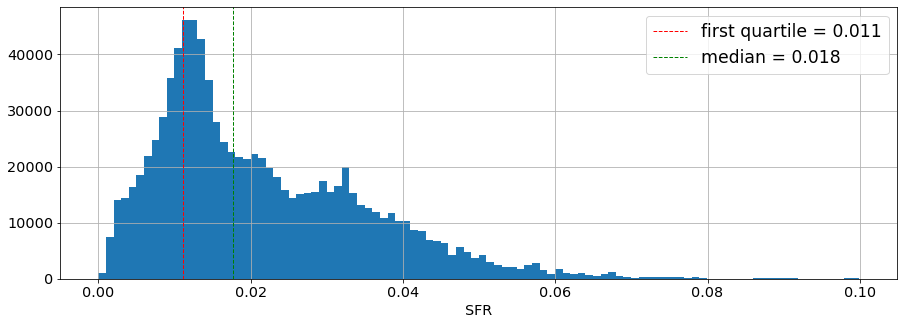

In [282]:
feed_filled[feed_filled.SFR<.1].SFR.hist(bins=100)
plt.axvline(feed_filled.SFR.quantile(.25), color='red', linestyle='dashed', label=f'first quartile = {feed_filled.SFR.quantile(.25):.3f}', linewidth=1)
plt.axvline(feed_filled.SFR.quantile(.5), color='green', linestyle='dashed', label=f'median = {feed_filled.SFR.quantile(.5):.3f}', linewidth=1)

# plt.axvline(means[0], color='red', linestyle='dashed', label=f'second mode = {means[0]:.3f}', linewidth=1)

# # Display the modes as text on the plot
# plt.text(0.6, 0.9, f"Modes: {means[0]:.3f}, {means[1]:.3f}", transform=plt.gca().transAxes)

plt.legend()
plt.xlabel('SFR')
# plt.savefig('Visualisation\Histograms\SFR_FW_aggregated_on_final_locus_population_histogram.jpg')

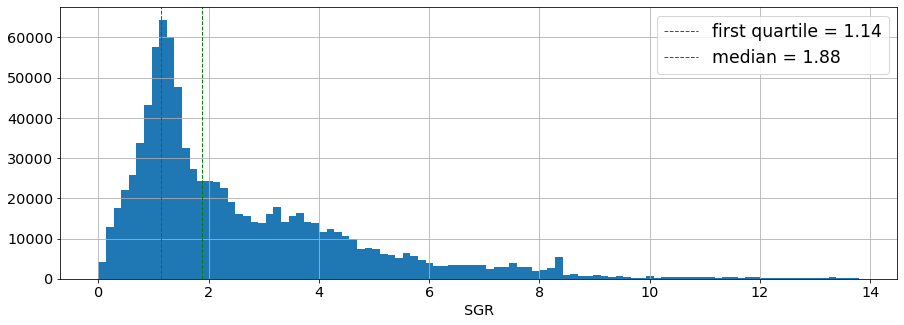

In [312]:
#here we remove very high SGR for very small fish
feed_filled[feed_filled.SGR.between(0,feed_filled.SGR.quantile(.99))].SGR.hist(bins=100)
plt.axvline(feed_filled.SGR.quantile(.25), color='red', linestyle='dashed', label=f'first quartile = {feed_filled.SGR.quantile(.25):.2f}', linewidth=1)
plt.axvline(feed_filled.SGR.quantile(.5), color='green', linestyle='dashed', label=f'median = {feed_filled.SGR.quantile(.5):.2f}', linewidth=1)

# feed_filled.SGR.hist(bins=100)


# plt.axvline(feed_filled.SFR.quantile(.25), color='red', linestyle='dashed', label=f'first quartile = {feed_filled.SFR.quantile(.25):.3f}', linewidth=1)
# plt.axvline(feed_filled.SFR.quantile(.5), color='green', linestyle='dashed', label=f'median = {feed_filled.SFR.quantile(.5):.3f}', linewidth=1)

# plt.axvline(means[0], color='red', linestyle='dashed', label=f'second mode = {means[0]:.3f}', linewidth=1)

# # Display the modes as text on the plot
# plt.text(0.6, 0.9, f"Modes: {means[0]:.3f}, {means[1]:.3f}", transform=plt.gca().transAxes)

plt.legend()
plt.xlabel('SGR')
# plt.savefig('Visualisation\Histograms\SGR_FW_aggregated_on_final_locus_population_histogram.jpg')

In [328]:
# Fit a Gaussian Mixture Model to calculate two modes
gmm = GaussianMixture(n_components=4)
gmm.fit(feed_filled[feed_filled.FCR.between(0.7,1.2)]['FCR'].values.reshape(-1, 1))

# Get the means of the Gaussian components
means = gmm.means_.flatten()

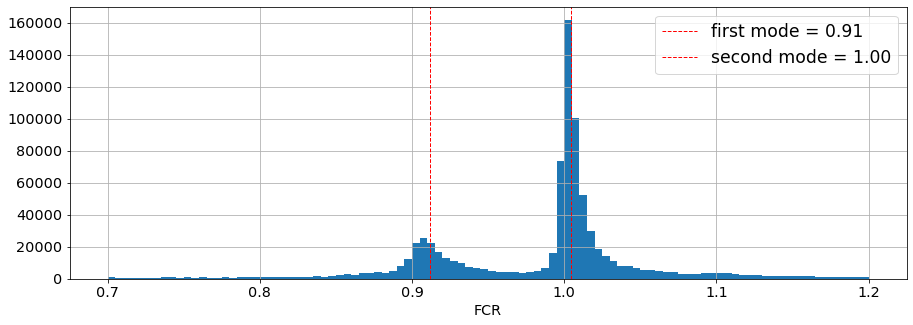

In [331]:
feed_filled[feed_filled.FCR.between(0.7,1.2)].FCR.hist(bins=100)
# feed_filled.FCR.hist(bins=100)

plt.axvline(means[1], color='red', linestyle='dashed', label=f'first mode = {means[1]:.2f}', linewidth=1)
plt.axvline(means[0], color='red', linestyle='dashed', label=f'second mode = {means[0]:.2f}', linewidth=1)
# plt.axvline(feed_filled.FCR.quantile(.25), color='red', linestyle='dashed', label=f'first quartile = {feed_filled.FCR.quantile(.25):.3f}', linewidth=1)
# plt.axvline(feed_filled.FCR.quantile(.5), color='green', linestyle='dashed', label=f'median = {feed_filled.FCR.quantile(.5):.3f}', linewidth=1)

# plt.axvline(means[0], color='red', linestyle='dashed', label=f'second mode = {means[0]:.3f}', linewidth=1)

# # Display the modes as text on the plot
# plt.text(0.6, 0.9, f"Modes: {means[0]:.3f}, {means[1]:.3f}", transform=plt.gca().transAxes)

plt.legend()
plt.xlabel('FCR')
# plt.savefig('Visualisation\Histograms\FCR_FW_aggregated_on_final_locus_population_histogram.jpg')

In [ ]:
#end plotting histograms

In [32]:
feed_filled.dropna().to_csv('../data/feed_data_extended_unsmoothed.csv',index=False)

In [ ]:
#to be finished

In [33]:
full_cycles = [
    194527129, 
    194497496,
    193247058,
    194516980,
    194546436,
    38193840,
    194352023,
    194503079,
    193343886,
    194530157,
    194497483,
    194503096,
    194522881,
    193249474,
    193247433,
    194523185,
    194512165
]

### Non-smoothed

In [121]:
def plot_ph_full_cycle(ph_full_cycle: pd.DataFrame,
                       fresh_water_dates_df: pd.DataFrame,
                       full_cycle_id: int,
                       save_dir: Path,
                       smoothed: bool = False):
    if ph_full_cycle['SFR'].isna().sum() == ph_full_cycle['SFR'].shape[0]:
        return

    fig, axs = plt.subplots(1, 1)
    sns.lineplot(data=ph_full_cycle, x='event_date', y='SFR')

    min_ph = ph_full_cycle['SFR'].min()
    first_movement_date = ph_full_cycle['event_date'].min()
    hatching_date = ph_full_cycle.dropna()['event_date'].min()  # not exact definition of hatching date
    shipout_date = ph_full_cycle['event_date'].max()
#     first_feeding_date = fresh_water_dates_df[fresh_water_dates_df.pretransfer_fw_locus_population_id==lp].first_feeding_date.iloc[0]
    first_feeding_date = ph_full_cycle[ph_full_cycle.SFR>0]['event_date'].min()

    plt.xlim(first_movement_date - datetime.timedelta(days=7), shipout_date + datetime.timedelta(days=7))
    axs.xaxis.set_major_formatter(mdates.DateFormatter(TIME_FORMAT))

    if (hatching_date-first_movement_date).days<7:
        dates_dict = {
#             'hatching_date': hatching_date,
            'first_feeding_date': first_feeding_date,
            'shipout_date': shipout_date
        }
    else:
        dates_dict = {
            'first_movement_date': first_movement_date,
#             'hatching_date': hatching_date,
            'first_feeding_date': first_feeding_date,
            'shipout_date': shipout_date
        }

    for i, (name, date) in enumerate(dates_dict.items()):
        plt.axvline(date, linestyle='--')
        plt.text(date + datetime.timedelta(days=1), min_ph, f'{name} = {date.strftime(TIME_FORMAT)}', rotation=90)
    
    chart_title = f"""final_locus_population_id = {full_cycle_id}, FW cycle length (from hatching) = {len(ph_full_cycle.dropna())} days, FW cycle length (incl. incubation)='{len(ph_full_cycle)} days"""
#     chart_title = 'final_locus_population_id='+str(lp)+', FW cycle length (from hatching)='+str(len(filtered_df.dropna()))+' days' +', FW cycle length (incl. incubation)='+str(len(filtered_df))+' days' 
    plt.show()
    save_path = save_dir / f'SFR_vs_time_{full_cycle_id}.png' if not smoothed else save_dir / f'SFR_vs_time_{full_cycle_id}_smoothed.png'
    fig.savefig(save_path)
    plt.close()

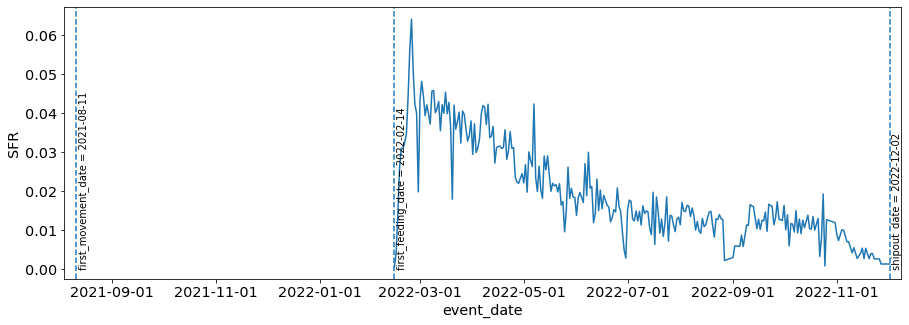

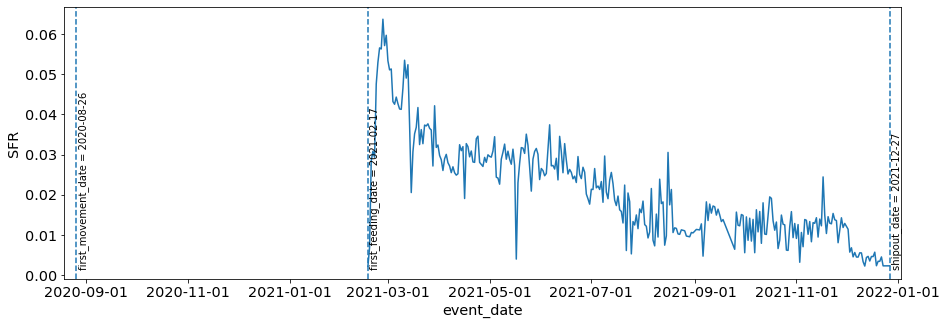

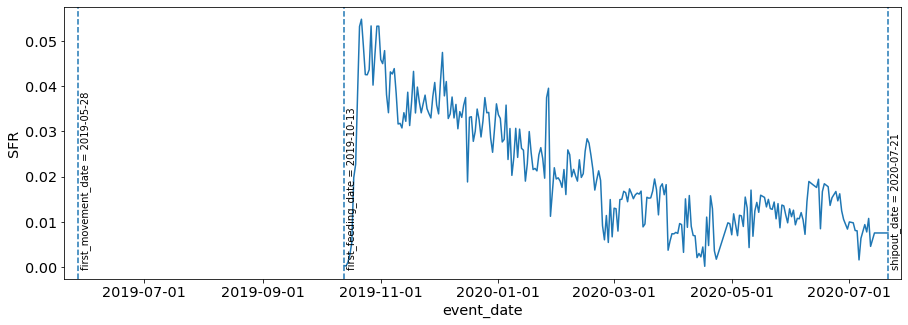

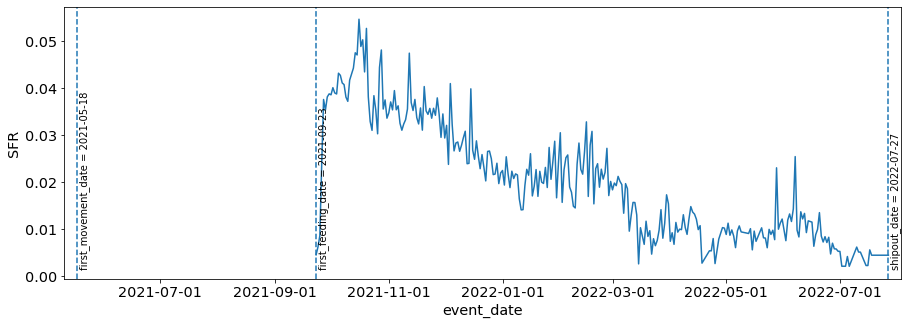

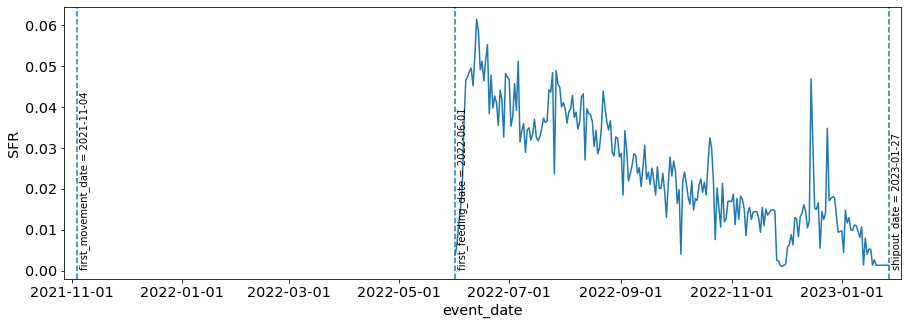

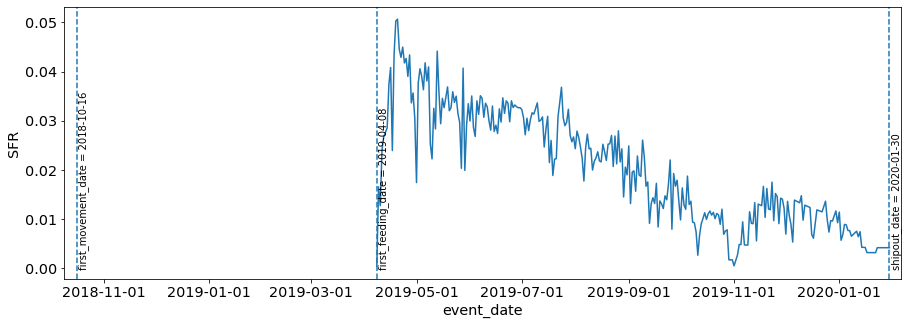

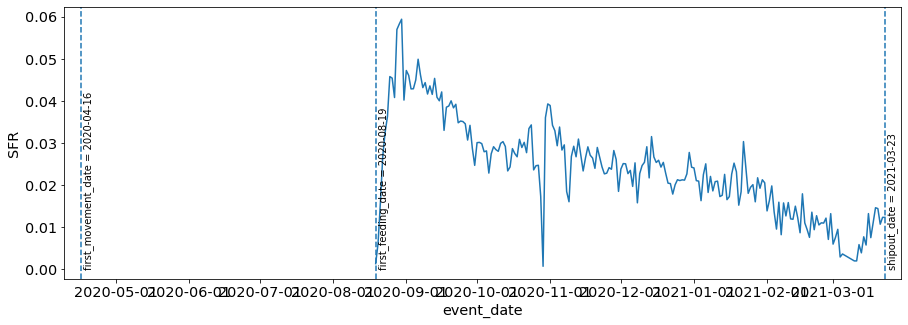

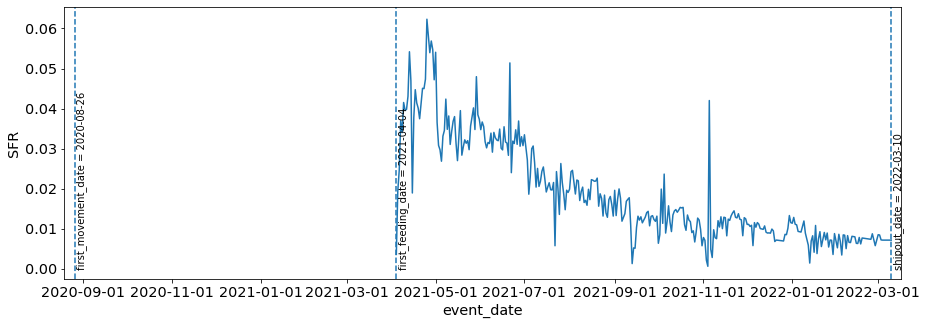

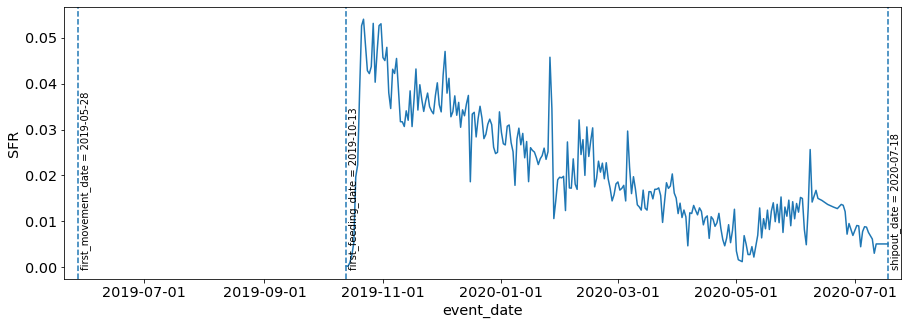

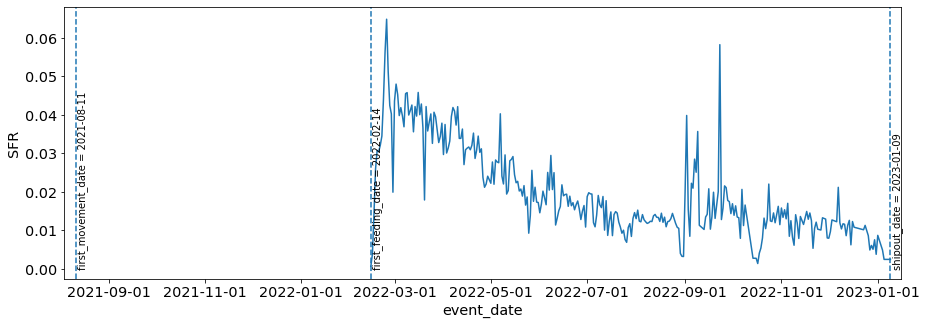

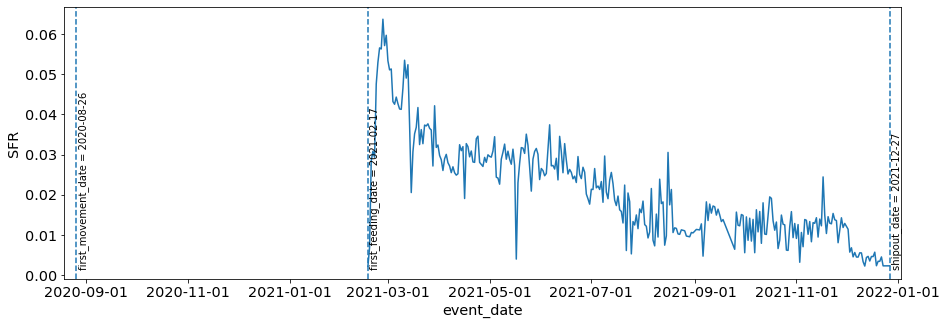

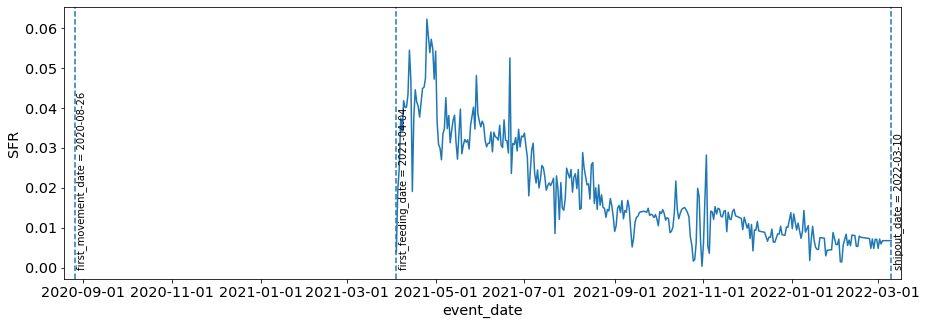

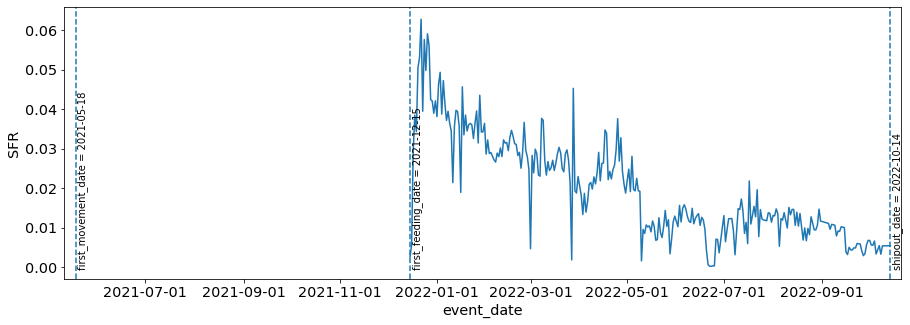

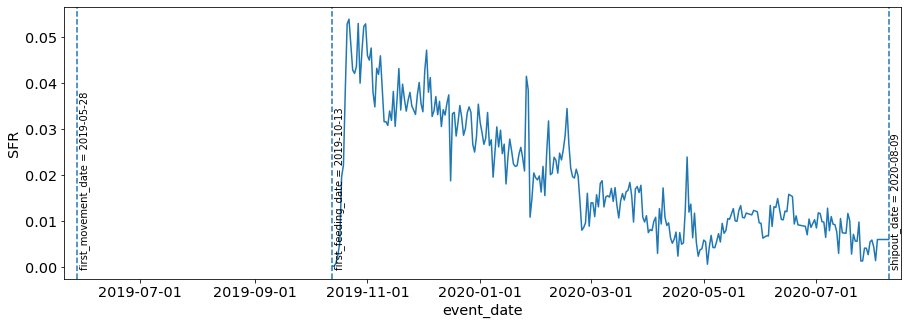

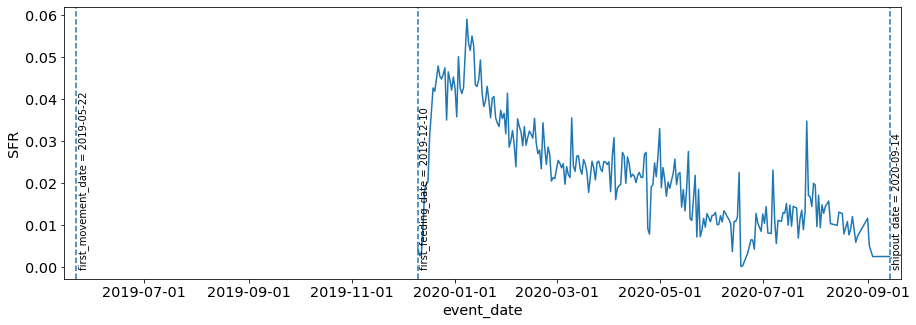

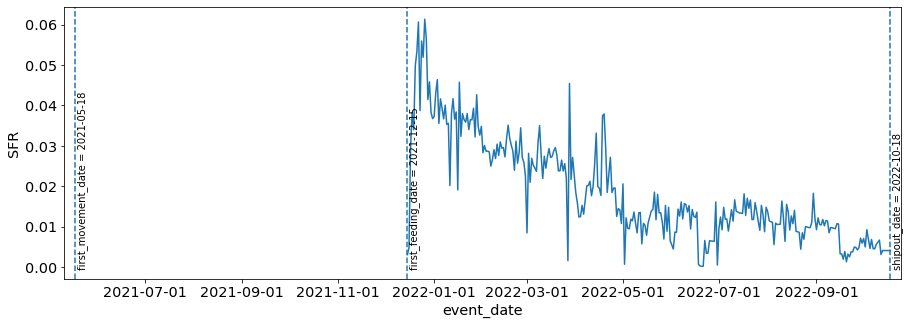

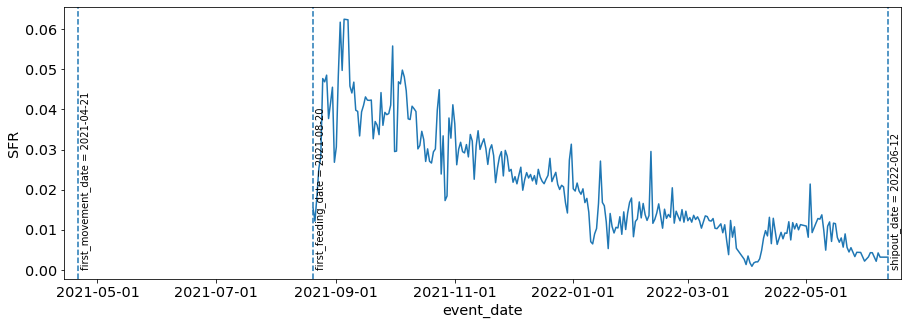

In [122]:
save_dir = Path('./img')
save_dir.mkdir(parents=True, exist_ok=True)

for full_cycle_id in full_cycles:
    ph_full_cycle = feed_filled[feed_filled['final_locus_population_id'] == full_cycle_id]
    plot_ph_full_cycle(ph_full_cycle, fresh_water_dates, full_cycle_id, save_dir)

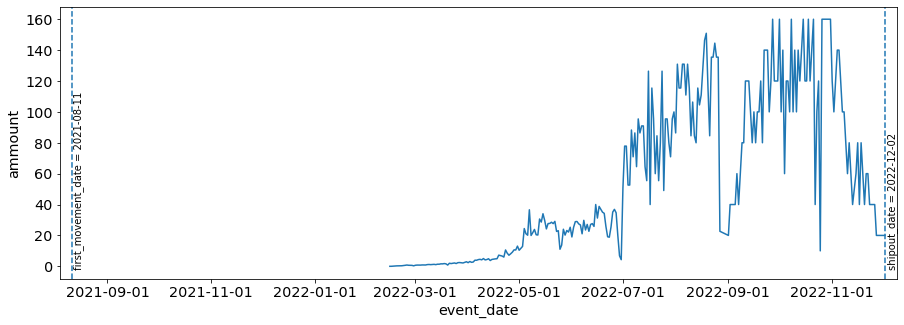

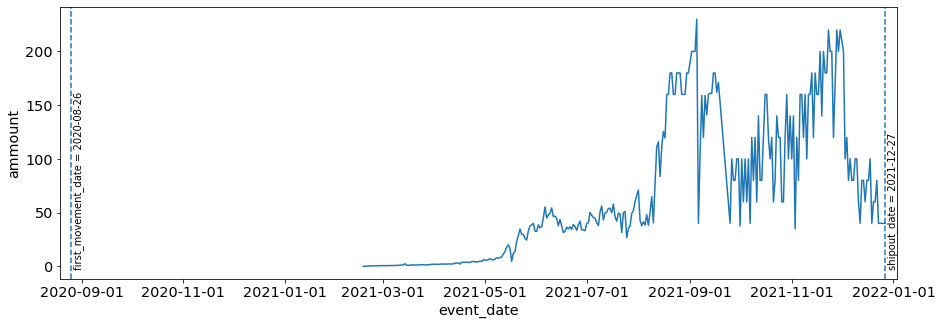

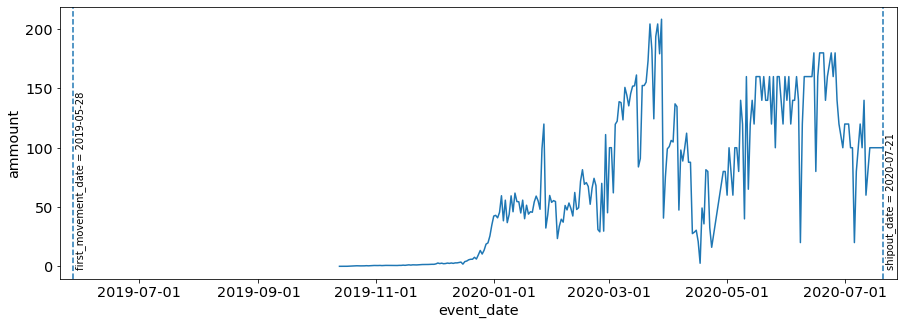

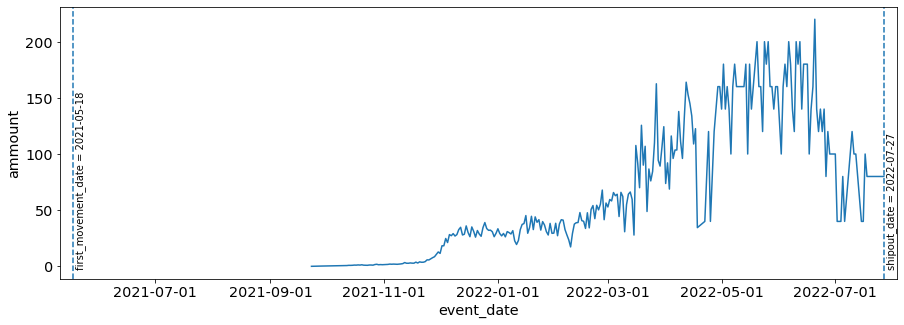

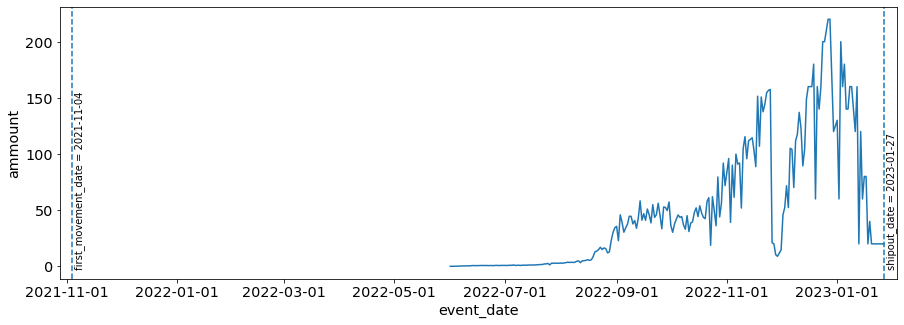

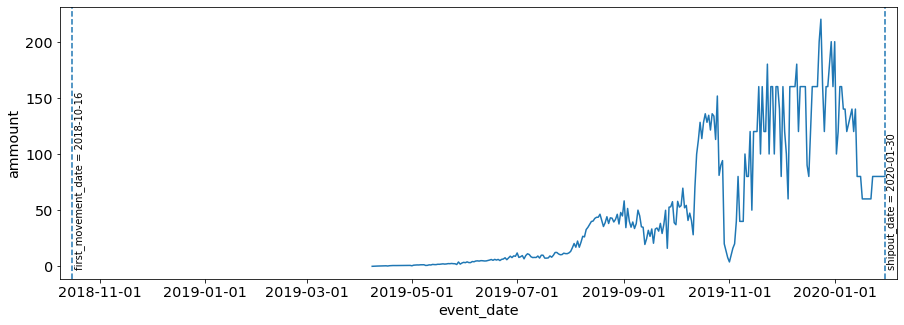

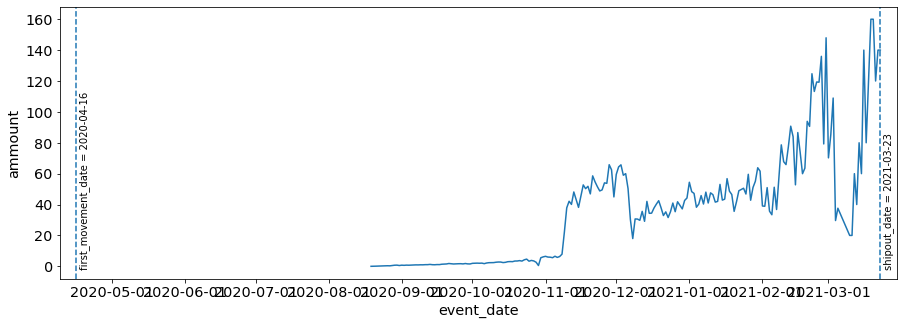

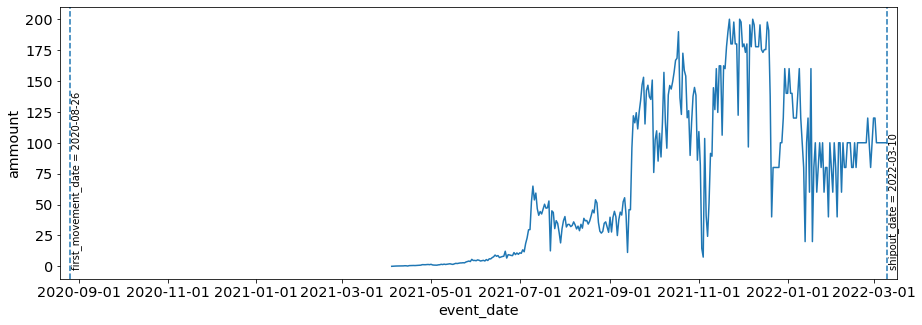

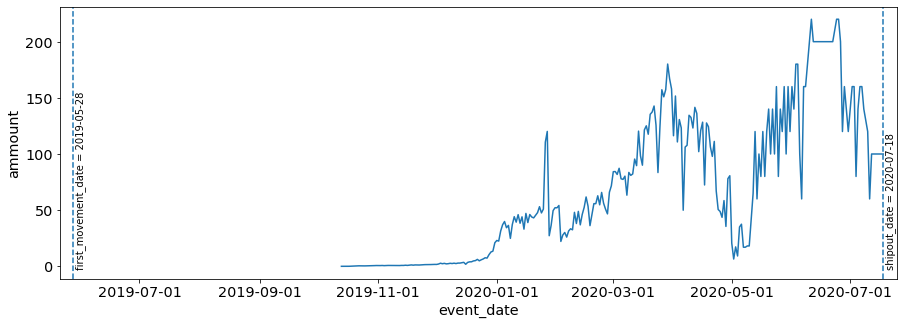

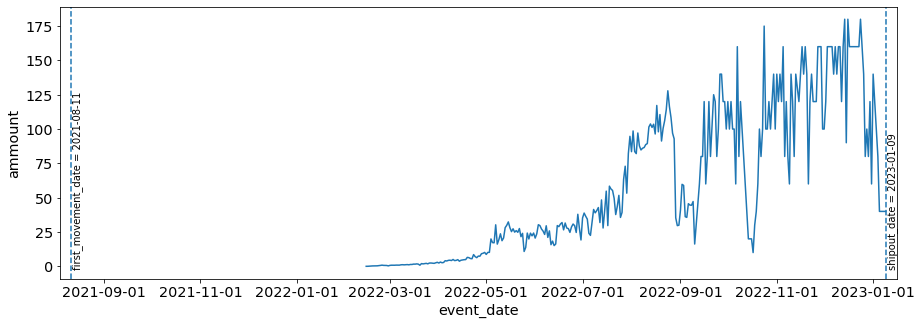

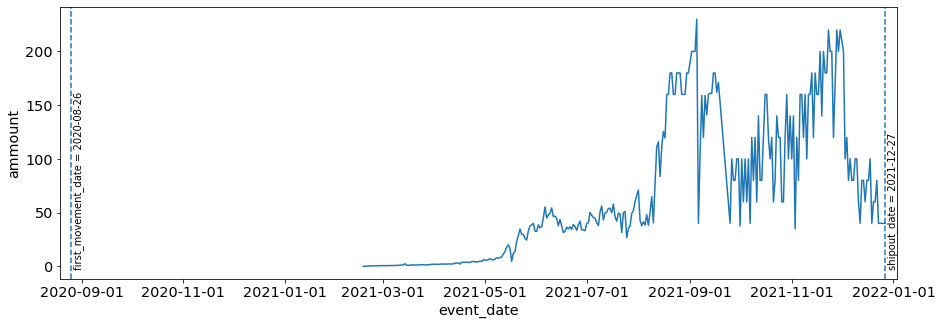

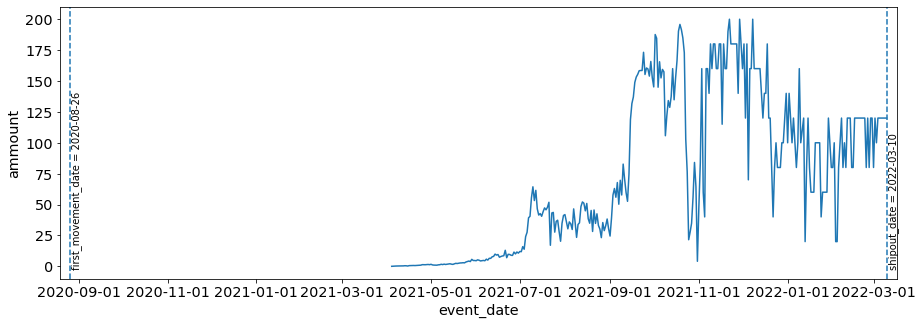

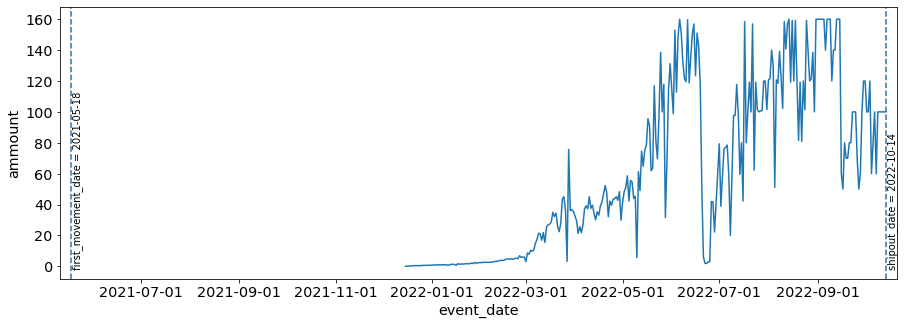

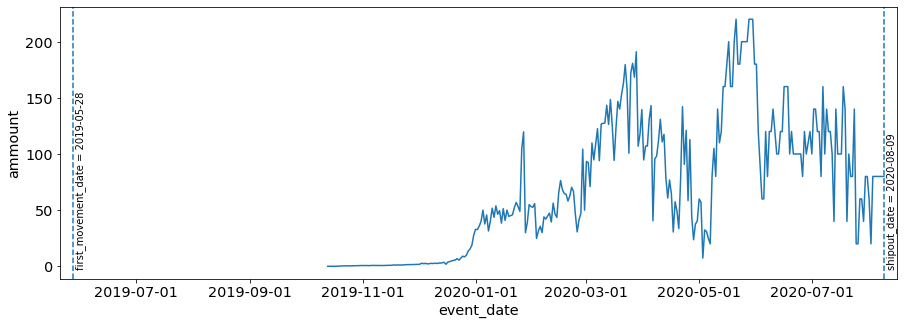

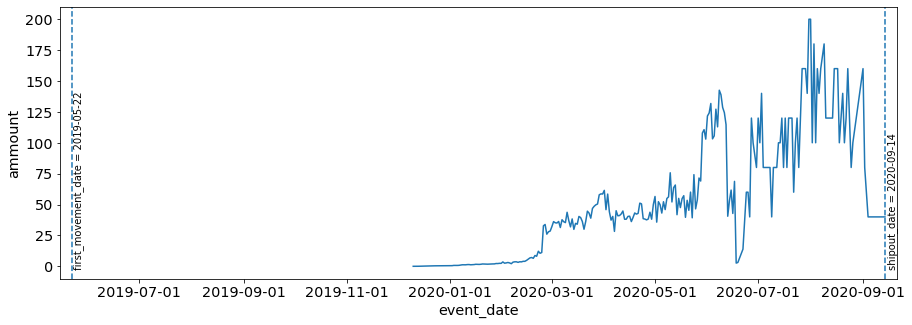

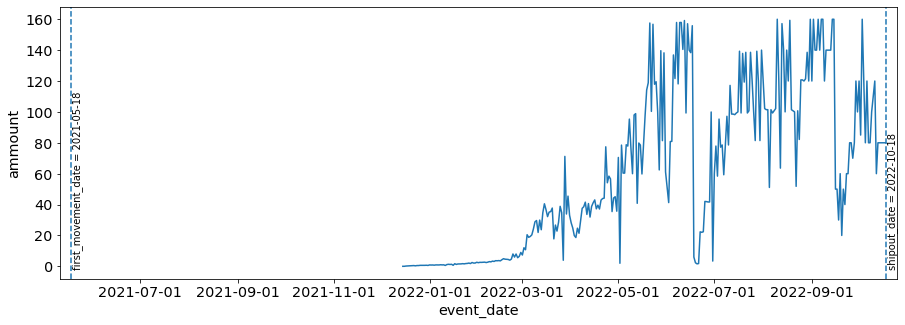

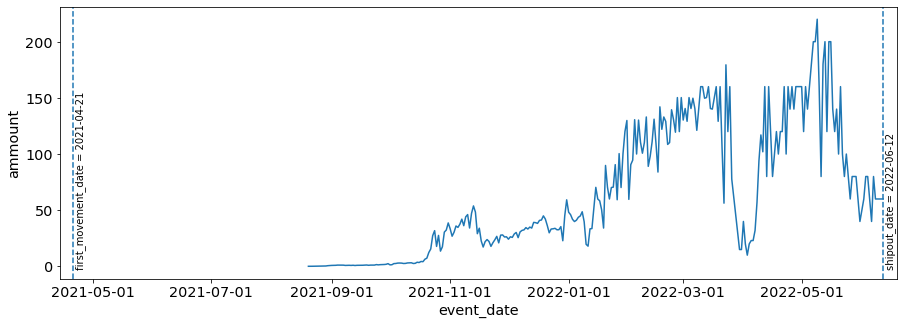

In [56]:
# save_dir = Path('./img')
# save_dir.mkdir(parents=True, exist_ok=True)

# for full_cycle_id in full_cycles:
#     ph_full_cycle = feed_filled[feed_filled['final_locus_population_id'] == full_cycle_id]
#     plot_ph_full_cycle(ph_full_cycle, fresh_water_dates, full_cycle_id, save_dir)

### Smoothing

In [34]:
def get_mean_last_week(df, x):
    df = df.copy().reset_index()
    idx = df[df['ph'] == x].index[0]
    if idx == 391:
        print(x)
    if idx > 7:
        return df['ph'].iloc[idx-7:idx].mean(skipna=True)
    else:
        return df['ph'].iloc[:idx].mean(skipna=True)

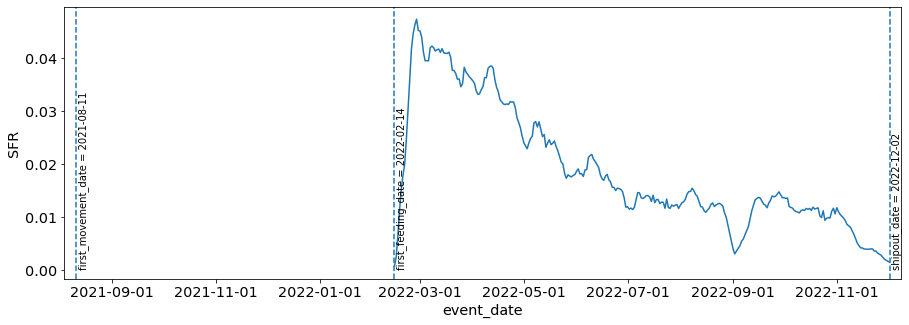

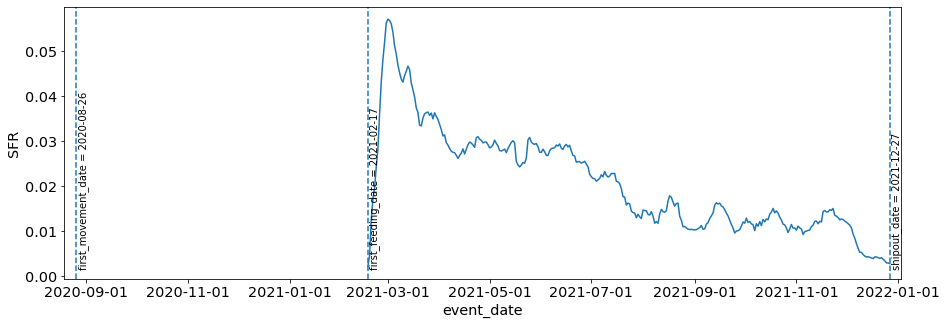

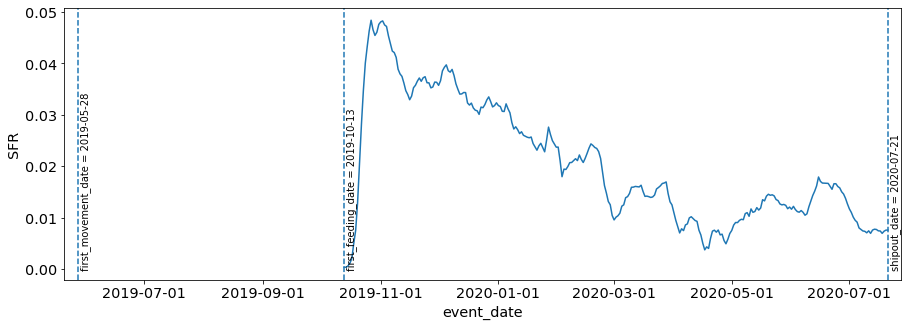

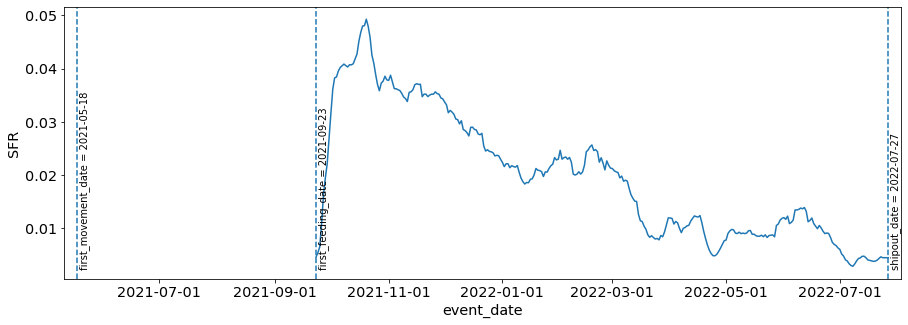

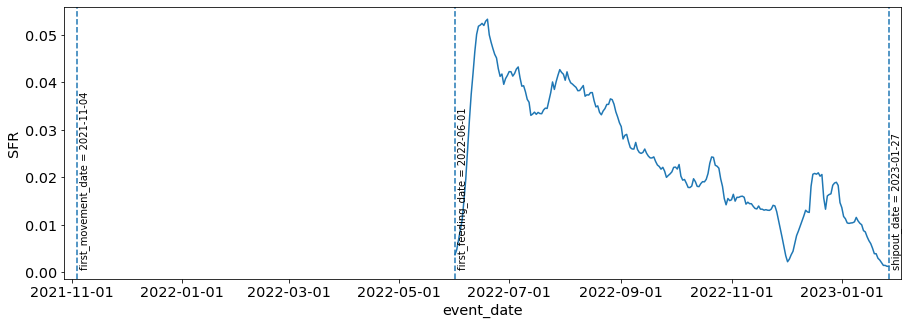

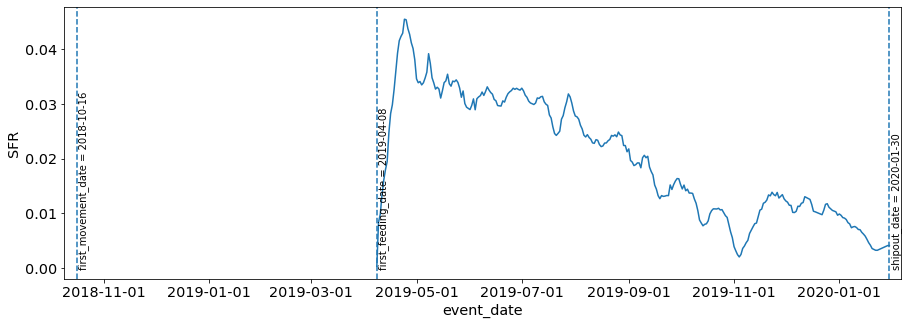

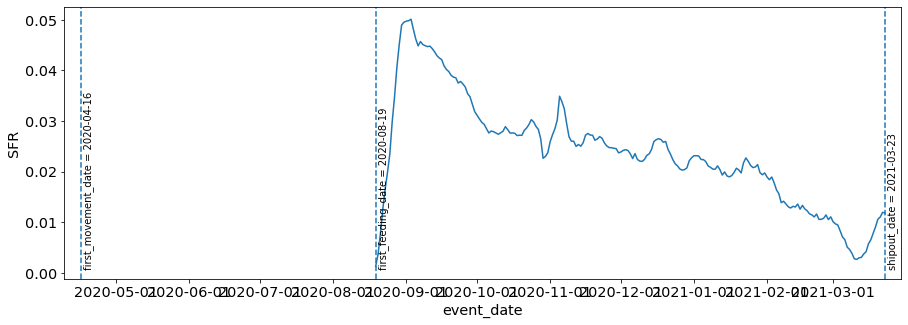

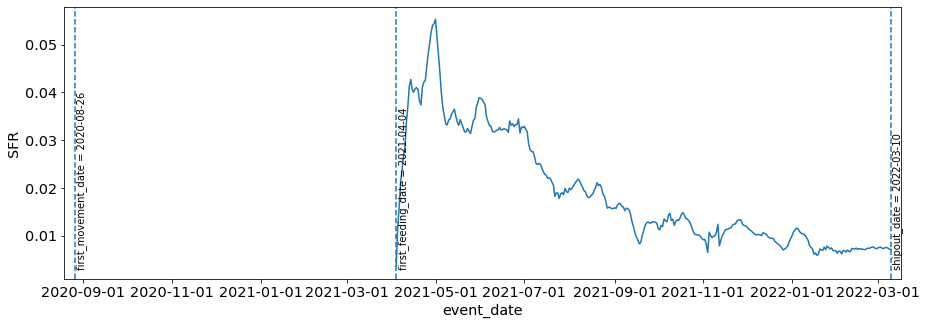

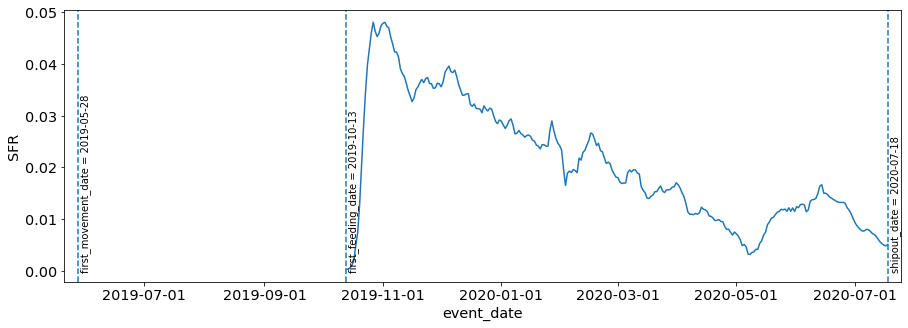

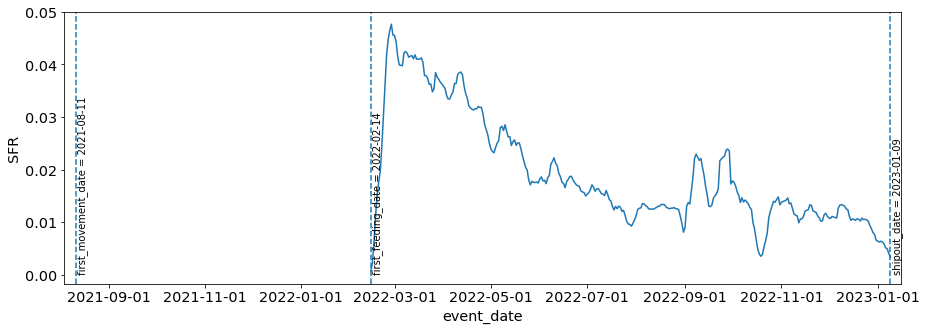

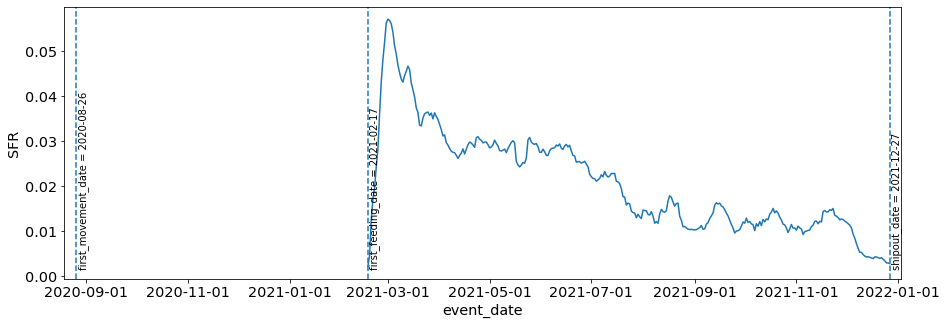

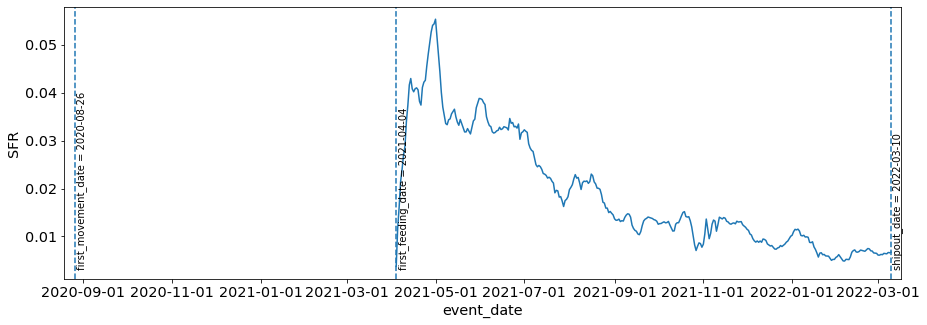

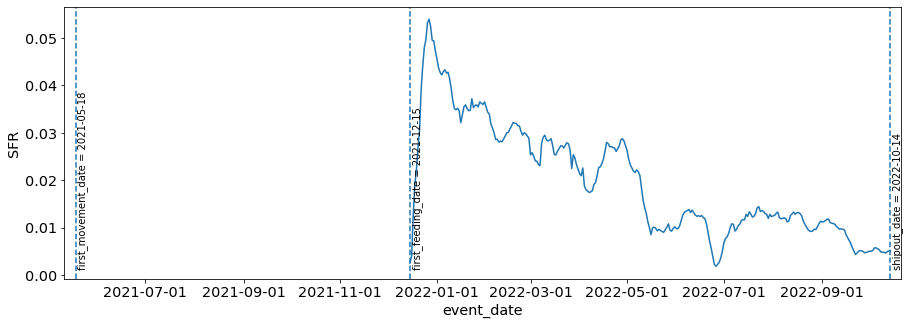

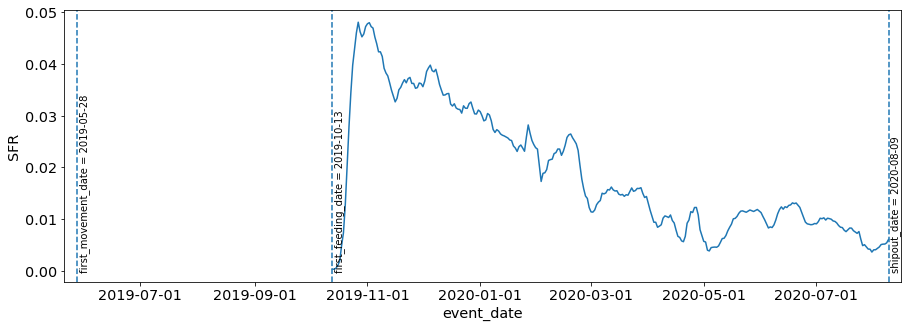

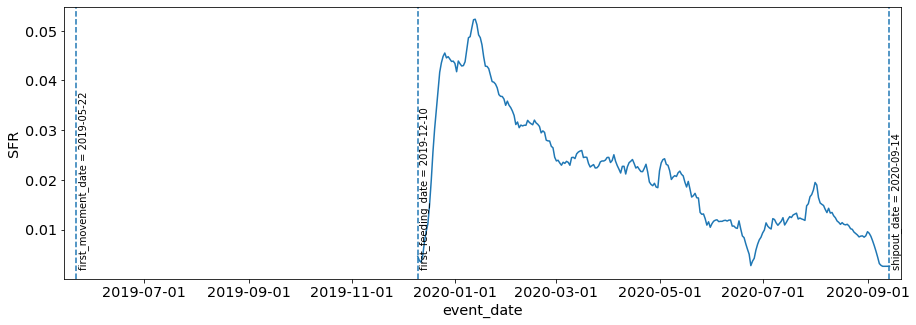

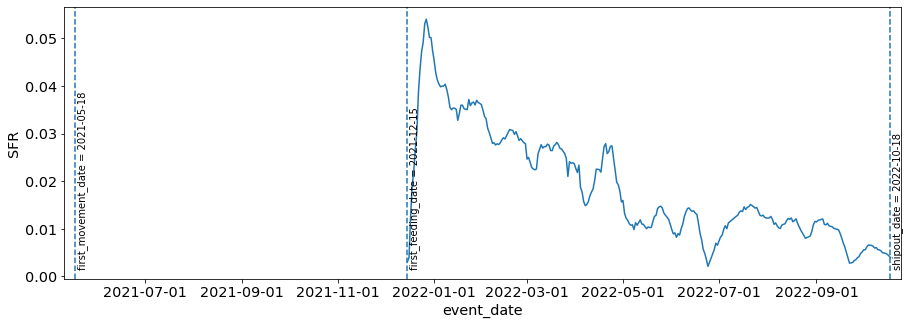

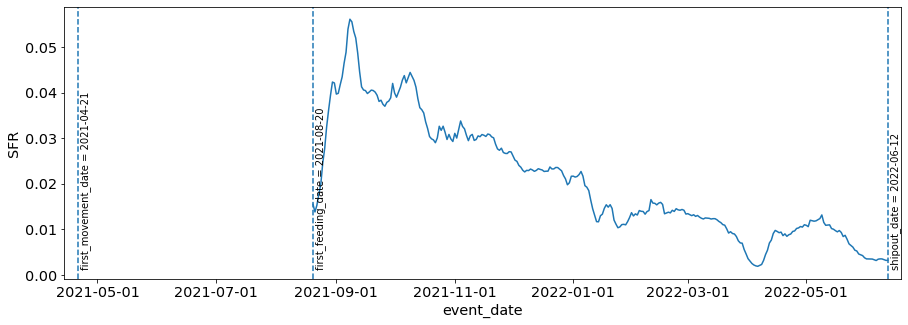

In [124]:
save_dir = Path('./img')
save_dir.mkdir(parents=True, exist_ok=True)

for full_cycle_id in full_cycles:
    ph_full_cycle = feed_filled[feed_filled['final_locus_population_id'] == full_cycle_id]
    smoothed_ph_full_cycle = ph_full_cycle.copy()
    
    smoothed_ph_full_cycle['SFR'] = smoothed_ph_full_cycle['SFR'].rolling(7, min_periods=1).mean()

#     smoothed_ph_full_cycle['ph'] = smoothed_ph_full_cycle['ph'].\
#     apply(lambda x: x if pd.isna(x) or (x > 6.5 and x < 8) else get_mean_last_week(smoothed_ph_full_cycle, x))

    plot_ph_full_cycle(smoothed_ph_full_cycle, fresh_water_dates, full_cycle_id, save_dir, smoothed=True)

In [35]:
feed_data_smoothed = []

for full_cycle_id in tqdm(feed_filled.final_locus_population_id.unique()):
    ph_full_cycle = feed_filled[feed_filled['final_locus_population_id'] == full_cycle_id]
    smoothed_ph_full_cycle = ph_full_cycle.copy()
    smoothed_ph_full_cycle['SFR'] = smoothed_ph_full_cycle['SFR'].rolling(7, min_periods=1).mean()

    feed_data_smoothed.append(smoothed_ph_full_cycle)
feed_data_smoothed = pd.concat(feed_data_smoothed)

100%|██████████| 4192/4192 [00:15<00:00, 270.65it/s]


In [36]:
feed_filled.to_csv('../data/feed_SFR_data_unsmoothed.csv', index=False)
feed_data_smoothed.to_csv('../data/feed_SFR_data_smoothed.csv', index=False)

In [131]:
feed_data_smoothed.SFR.describe()

count    933780.000000
mean          0.020387
std           0.011897
min           0.000000
25%           0.010909
50%           0.017660
75%           0.029217
max           0.063122
Name: SFR, dtype: float64

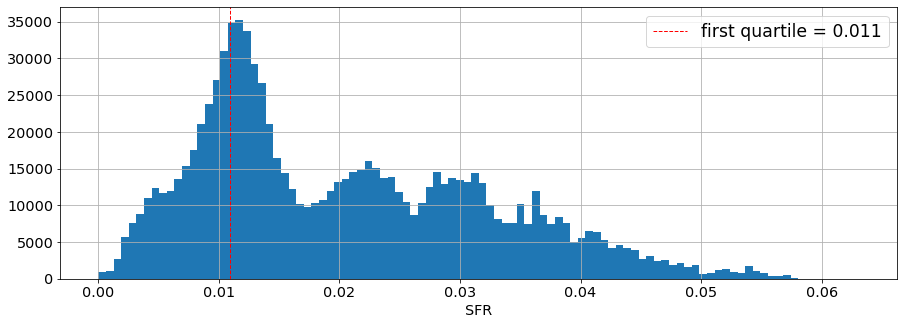

In [151]:
check_dates=pd.DataFrame(feed_filled[~feed_filled.SFR.isna()].groupby('final_locus_population_id')['event_date'].min())
check_dates

,event_date
final_locus_population_id,
36783130,2017-08-12
36783339,2017-08-12
36783413,2017-08-12
36783453,2017-08-12
36783456,2017-08-12
...,...
194650512,2022-04-12
194650513,2022-04-12
194650515,2022-04-12


In [166]:
# check first feeding date
# tmp=pd.read_csv('data\FW_cycle_dates.csv')
# check_tmp=tmp[tmp.pretransfer_fw_locus_population_id.isin(check_dates.index)].merge(check_dates.reset_index(),how='left',left_on='pretransfer_fw_locus_population_id',right_on='final_locus_population_id')
# check_tmp
# check_tmp ['event_date'] = pd.to_datetime(check_tmp['event_date'],format=TIME_FORMAT)
# check_tmp ['first_feeding_date'] = pd.to_datetime(check_tmp ['first_feeding_date'],format=TIME_FORMAT)
# check_tmp['date_diff'] = (check_tmp ['event_date'] -check_tmp ['first_feeding_date']).dt.days
# check_tmp['date_diff'].describe()

count    3176.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: date_diff, dtype: float64

1. gc.collect() or other memory cleaning
2. try groupby locus_id
3. unsmoothed data full pipeline

<AxesSubplot:>

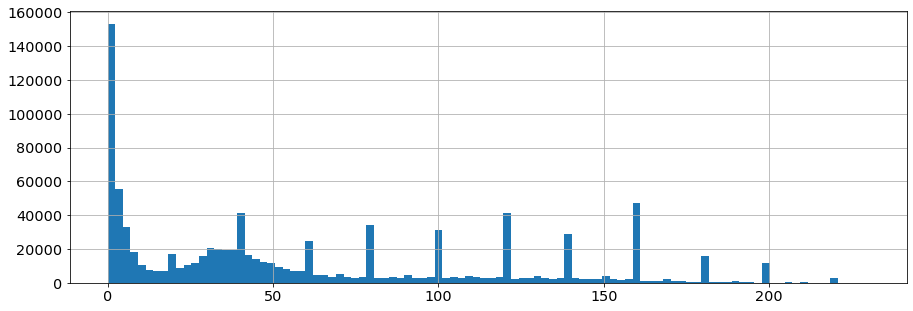

In [66]:
feed_filled.ammount.hist(bins=100)

<AxesSubplot:>

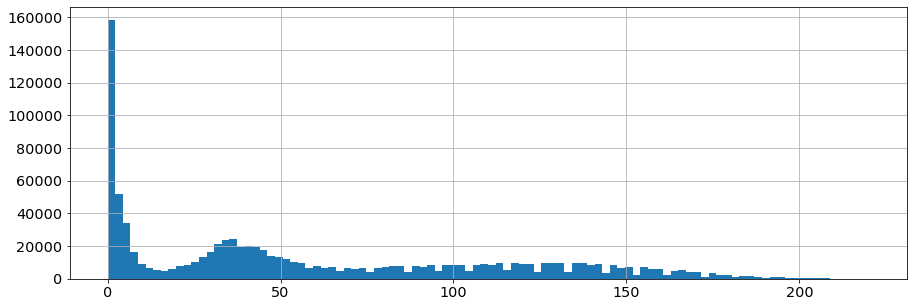

In [65]:
feed_data_smoothed.ammount.hist(bins=100)

In [311]:
feed_filled

,final_locus_population_id,event_date,amount,SFR,close_count,close_weight_g
0,36783130,2017-01-04,NaN,NaN,NaN,NaN
1,36783130,2017-01-05,NaN,NaN,NaN,NaN
2,36783130,2017-01-06,NaN,NaN,NaN,NaN
3,36783130,2017-01-07,NaN,NaN,NaN,NaN
4,36783130,2017-01-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1484517,194650523,2023-02-25,60.0,0.003272,71841.0,255.27
1484518,194650523,2023-02-26,60.0,0.003272,71841.0,255.27
1484519,194650523,2023-02-27,60.0,0.003272,71841.0,255.27
1484520,194650523,2023-02-28,60.0,0.003272,71841.0,255.27


In [314]:
feed_filled[(feed_filled.final_locus_population_id==36783130)].dropna().head(20)#&(feed_filled.event_date=='2017-08-12')]

,final_locus_population_id,event_date,amount,SFR,close_count,close_weight_g
220,36783130,2017-08-12,0.007082,0.001496,13840.055850,0.042272
221,36783130,2017-08-13,0.014014,0.002932,20839.921560,0.062644
222,36783130,2017-08-14,0.030679,0.006333,28300.985890,0.085016
223,36783130,2017-08-15,0.056870,0.011204,34628.408380,0.106410
224,36783130,2017-08-16,0.099811,0.019773,40274.853150,0.124344
225,36783130,2017-08-17,0.168910,0.031662,40256.892905,0.131911
226,36783130,2017-08-18,0.172230,0.031245,40239.987000,0.135617
227,36783130,2017-08-19,0.291363,0.049389,40231.641455,0.144883
228,36783130,2017-08-20,0.301476,0.048064,40223.831610,0.153172
229,36783130,2017-08-21,0.339957,0.050753,38208.688915,0.156737
